In [1]:
import print_n_log

In [2]:
# Parameters for Preprocessing Notebook
#---------------------------------------------
IS_MASTER = True # Remember this? We need to set this to True in MASTER Notebook so that it does not use the default parameters in processing notebook.
RAW_FILE = f'/path/to/smallData.csv' # use "small data" here
DATA_DIR = './data/'

PROCESSED_FILE = f'{DATA_DIR}processed.pkl' # always use pickle for fast I/O!
OTHER_PREPROCESS_PARAMETER = ... # like batch size, sliding

# Let's save the original print method in ori_print
#---------------------------------------------------
ori_print = print

# Now we set the print method to be modified print
#--------------------------------------------------
print = print_n_log.run('preproc', './logs/experiment1.log', 'DEBUG')

In [3]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [4]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [5]:
plotPath = "exp/exp1/plot.png"
modelPath = "exp/exp1/mask_detector.model"

In [6]:
# Now, we run the Model Notebook using the %run magic (You can change your model based on your self-defined architecture)
#-------------------------------------------------------------
%run "b_preprocess.ipynb"

2020-10-06 10:43:58,691 - preproc - INFO - [MASTER] using big dataset...
2020-10-06 10:43:58,697 - preproc - INFO - [INFO] loading images...


In [7]:
# Now, we run the Model Notebook using the %run magic (You can change your model based on your self-defined architecture)
#-------------------------------------------------------------
%run "c_model_cnn.ipynb"

C:\Users\user\Anaconda3\envs\dlgpu\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [8]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

2020-10-06 10:44:05,632 - preproc - INFO - [INFO] compiling model...


In [9]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

2020-10-06 10:44:05,697 - preproc - INFO - [INFO] training head...


  ...
    to  
  ['...']
Train for 34 steps, validate on 276 samples
Epoch 1/20
34/34 [==============================] - 14s 408ms/step - loss: 0.7621 - accuracy: 0.5852 - val_loss: 0.4628 - val_accuracy: 0.7695
Epoch 2/20
34/34 [==============================] - 11s 327ms/step - loss: 0.4266 - accuracy: 0.8127 - val_loss: 0.2720 - val_accuracy: 0.9062
Epoch 3/20
34/34 [==============================] - 11s 330ms/step - loss: 0.3179 - accuracy: 0.8736 - val_loss: 0.2321 - val_accuracy: 0.9180
Epoch 4/20
34/34 [==============================] - 11s 325ms/step - loss: 0.2436 - accuracy: 0.9073 - val_loss: 0.1596 - val_accuracy: 0.9531
Epoch 5/20
34/34 [==============================] - 11s 328ms/step - loss: 0.1975 - accuracy: 0.9298 - val_loss: 0.1240 - val_accuracy: 0.9727
Epoch 6/20
34/34 [==============================] - 11s 334ms/step - loss: 0.1830 - accuracy: 0.9363 - val_loss: 0.1093 - val_accuracy: 0.9688
Epoch 7/20
34/34 [==============================] - 11s 325ms/step - loss

In [10]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

2020-10-06 10:48:00,467 - preproc - INFO - [INFO] evaluating network...


In [11]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [12]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

2020-10-06 10:48:02,482 - preproc - INFO -                               precision    recall  f1-score   support

   ./data/big_data/with_mask       0.97      1.00      0.98       138
./data/big_data/without_mask       1.00      0.96      0.98       138

                    accuracy                           0.98       276
                   macro avg       0.98      0.98      0.98       276
                weighted avg       0.98      0.98      0.98       276



In [13]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save(modelPath, save_format="h5")

2020-10-06 10:48:02,499 - preproc - INFO - [INFO] saving mask detector model...


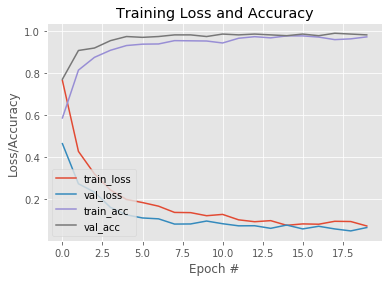

In [14]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plotPath)